In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import graphviz
import seaborn as sns; sns.set()
from sklearn.linear_model import SGDClassifier 
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import *
import time

%matplotlib inline

In [38]:
#This loop only using all the possible data
df = pd.read_csv('final_data.csv')

In [ ]:
#Check the prob of re-entry within one year
df['within_one'].sum()/df.shape[0]

In [39]:
df.columns

Index(['mni_no', 'dedupe_id', 'dob', 'sex', 'race', 'mar_stat', 'city',
       'state', 'zip', 'case_no', 'case_type', 'booking_no',
       'arresting_agency', 'arresting_agency_type', 'booking_date',
       'release_date', 'bail_type', 'bail_amt', 'bailed_out', 'pri_dx_value',
       'refferal_source', 'mh_treatment', 're_entry', 'age', '1yr', 'stayed',
       'after_released', 'within_one'],
      dtype='object')

In [40]:
df = df.drop(['re_entry', 'age', '1yr', 'stayed', 'mni_no', 'dedupe_id', 'dob', 'city', 'zip', 'release_date', 'case_no', 'booking_no'], axis=1)

In [41]:
df.columns

Index(['sex', 'race', 'mar_stat', 'state', 'case_type', 'arresting_agency',
       'arresting_agency_type', 'booking_date', 'bail_type', 'bail_amt',
       'bailed_out', 'pri_dx_value', 'refferal_source', 'mh_treatment',
       'after_released', 'within_one'],
      dtype='object')

In [42]:
df.head()

sex   race mar_stat state case_type                     arresting_agency  \
0  MALE  WHITE        S    KS        CR  JOHNSON COUNTY SHERIFF'S DEPARTMENT   
1  MALE  WHITE        S    KS        CR                          OLATHE P.D.   
2  MALE  WHITE        S    KS        CR  JOHNSON COUNTY SHERIFF'S DEPARTMENT   
3  MALE  WHITE        S    KS        DV                          LENEXA P.D.   
4  MALE  WHITE        S    KS        DV                          LENEXA P.D.   

  arresting_agency_type booking_date bail_type  bail_amt  bailed_out  \
0        COUNTY SHERIFF   2011-11-20       SUR    2500.0           0   
1                  CITY   2014-05-02       SUR    1500.0           1   
2        COUNTY SHERIFF   2014-12-03       SUR    5000.0           1   
3                  CITY   2015-03-26       SUR    1000.0           1   
4                  CITY   2016-02-24       SUR    2500.0           0   

                      pri_dx_value refferal_source  mh_treatment  \
0  UNSPECIFIED AFFECTIVE PSYCHOSIS             NaN             0   
1  UNSPECIFIED AFFECTIVE PSYCHOSIS             NaN             0   
2  UNSPECIFIED AFFECTIVE PSYCHOSIS             NaN             0   
3  UNSPECIFIED AFFECTIVE PSYCHOSIS             NaN             0   
4  UNSPECIFIED AFFECTIVE PSYCHOSIS             NaN             0   

   after_released  within_one  
0           138.0           1  
1           557.0           0  
2           198.0           1  
3           386.0           0  
4           334.0           1

In [43]:
dummy_vals = ['sex', 'race', 'state', 'mar_stat', 'case_type', 'arresting_agency', 'arresting_agency_type', 'bail_type', 'pri_dx_value',
       'refferal_source', ]

In [44]:
#generate dummy variable for specific column
def getting_dummy(df, col):
    '''
    Helper function to create dummy variables in dataframe for specific column
    This function will return dataframe
    '''
    dummies = pd.get_dummies(df[col]).rename(columns=lambda x: str(col)+ str(x))
    df = pd.concat([df, dummies], axis=1)
    df.drop([col], inplace=True, axis=1)
    return df

In [45]:
for dummy in dummy_vals:
    df = getting_dummy(df, dummy)

In [46]:
#4 GenerateFeatures/Predictors: discretize a continuous variable 
def discrete_val(df, cols, bins=4):
    '''
    Helper function to discrete the continueous variable in dataframe into 4 bins
    This function will return dictionary mapping column name to the bin values
    '''
    for col in cols:
        new = col+'_binned'
        df[new] = pd.cut(df[col], bins, include_lowest=True, labels = range(0,bins))
        df.drop([col], inplace=True, axis=1)
    return df

In [47]:
df = discrete_val(df, ['bail_amt'], 5)

In [48]:
indepv = list(df.columns)

In [49]:
indepv.remove('after_released')

In [50]:
indepv.remove('within_one')

In [53]:
indepv

['booking_date',
 'bailed_out',
 'mh_treatment',
 'sexFEMALE',
 'sexMALE',
 'raceASIAN',
 'raceBLACK OR AFRICAN AMERICAN',
 'raceWHITE',
 'stateAR',
 'stateCA',
 'stateCO',
 'stateFL',
 'stateGA',
 'stateHI',
 'stateIA',
 'stateID',
 'stateIL',
 'stateKS',
 'stateLA',
 'stateMI',
 'stateMO',
 'stateMS',
 'stateNB',
 'stateNC',
 'stateNE',
 'stateNV',
 'stateOH',
 'stateOK',
 'statePA',
 'stateTX',
 'stateUT',
 'stateVA',
 'stateWI',
 'mar_statD',
 'mar_statM',
 'mar_statN',
 'mar_statS',
 'mar_statU',
 'mar_statW',
 'case_typeCR',
 'case_typeDV',
 'case_typeJV',
 'arresting_agencyFAIRWAY P.D.',
 'arresting_agencyGARDNER P.D.',
 'arresting_agencyJOHNSON COUNTY PARK PATROL',
 "arresting_agencyJOHNSON COUNTY SHERIFF'S DEPARTMENT",
 'arresting_agencyKANSAS HIGHWAY PATROL',
 'arresting_agencyLAKE QUIVIRA P.D.',
 'arresting_agencyLEAWOOD P.D.',
 'arresting_agencyLENEXA P.D.',
 'arresting_agencyMERRIAM P.D.',
 'arresting_agencyMISSION P.D.',
 'arresting_agencyOLATHE P.D.',
 'arresting_agencyO

In [35]:
def temporal_split(df, time_col, start_time, mid_time, end_time):
    train = df[(df[time_col] >= start_time) & (df[time_col] < mid_time) ]
    test = df[(df[time_col] >= mid_time)  & (df[time_col] < end_time)]
    return train, test

In [51]:
def split_data(train, test, y):
    '''
    Split the data into training and testing set
    
    And save them to run try different models
    '''
    x_test = test[indepv] 
    x_train = train[indepv]
    y_test = test[y]
    y_train = train[y]
    
    return x_train, x_test, y_train, y_test

In [52]:
train, test = temporal_split(df, 'booking_date', '2010-01-01', '2013-07-01', '2018-01-01' )

In [54]:
clfs = {'RF': RandomForestClassifier(),
    'Boost': AdaBoostClassifier(DecisionTreeClassifier(max_depth=1)),
    'Logit': LogisticRegression(),
    'SVM': SVC(probability=True, random_state=0),
    'Tree': DecisionTreeClassifier(),
    'Bag': BaggingClassifier(),
    'KNN': KNeighborsClassifier(),
    'ET': ExtraTreesClassifier(n_estimators=10, n_jobs=-1, criterion='entropy'),
    'NB': GaussianNB()}

small_grid = {'RF':{'n_estimators': [10,100], 'max_depth': [5,50], 'max_features': ['sqrt','log2'],'min_samples_split': [2,10]},
    'Boost': {'algorithm': ['SAMME', 'SAMME.R'], 'n_estimators': [1,10,100,1000]},
    'Logit': {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10]},
    'SVM' :{'C' :[0.01,0.1,1,10],'kernel':['linear']},
    'Tree': {'criterion': ['gini', 'entropy'], 'max_depth': [5,10,20,50], 'max_features': ['sqrt','log2'],'min_samples_split': [2,5]},
    'Bag':{'n_estimators':[1,10,20,50], 'max_samples':[5,10], 'max_features': [5,10]},
    'KNN' :{'n_neighbors': [1,10,50,100],'weights': ['uniform','distance'],'algorithm': ['auto','ball_tree','kd_tree']},
    'ET': {'n_estimators': [10,100], 'criterion' : ['gini', 'entropy'] ,'max_depth': [5,50], 'max_features': ['sqrt','log2'],'min_samples_split': [2,10], 'n_jobs': [-1]},
    'NB' : {}}

In [55]:
def generate_binary_at_k(y_scores, k):
    '''
    Set first k% as 1, the rest as 0.
    '''
    cutoff_index = int(len(y_scores) * (k / 100.0))
    test_predictions_binary = [1 if x < cutoff_index else 0 for x in range(len(y_scores))]
    return test_predictions_binary

In [56]:
def scores_at_k(y_true, y_scores, k):
    '''
    For a given level of k, calculate corresponding
    precision, recall, and f1 scores.
    '''
    preds_at_k = generate_binary_at_k(y_scores, k)
    precision = precision_score(y_true, preds_at_k)
    recall = recall_score(y_true, preds_at_k)
    f1 = f1_score(y_true, preds_at_k)
    return precision, recall, f1

In [57]:
def plot_precision_recall_n(y_true, y_score, model_name):
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_score)
    precision_curve = precision_curve[:-1]
    recall_curve = recall_curve[:-1]
    pct_above_per_thresh = []
    number_scored = len(y_score)
    for value in pr_thresholds:
        num_above_thresh = len(y_score[y_score>=value])
        pct_above_thresh = num_above_thresh / float(number_scored)
        pct_above_per_thresh.append(pct_above_thresh)
    pct_above_per_thresh = np.array(pct_above_per_thresh)
    plt.clf()
    fig, ax1 = plt.subplots()
    ax1.plot(pct_above_per_thresh, precision_curve, 'b')
    ax1.set_xlabel('percent of population')
    ax1.set_ylabel('precision', color='b')
    ax2 = ax1.twinx()
    ax2.plot(pct_above_per_thresh, recall_curve, 'r')
    ax2.set_ylabel('recall', color='r')
    
    name = model_name
    plt.title(name)
    plt.savefig(name)
    plt.show()

In [58]:
def plot(y_test, y_pred_probs, model, para = None):

    precision, recall, _ = precision_recall_curve(y_test, y_pred_probs)
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve for {} model: AUC={:.2f} \n with parameters: {}'.\
                        format(model, average_precision_score(y_test, y_pred_probs), para))
    plt.show()
    

def clf_loop(models, x_train, x_test, y_train, y_test):
    '''
    Run model with given params on x and y
    and print out the scores for comparison
    '''
    results_df = pd.DataFrame(columns=('model_type', 'parameters', 'accuracy','auc-roc', 'auc-pr', 'time', 'precision,recall,f1 at_5',
     'precision,recall,f1 at_10', 'precision,recall,f1 at_20', 'precision,recall,f1 at_30', 'precision,recall,f1 at_50'))
    for index, clf in enumerate([clfs[x] for x in models]):
        model_params = small_grid[models[index]]
        for p in ParameterGrid(model_params):
            try:
                start = time.time()
                clf.set_params(**p)
                y_pred_probs = clf.fit(x_train, y_train).predict_proba(x_test)[:,1]
                accuracy = clf.score(x_test, y_test)
                end = time.time()
                #Zip, unzip to ensure corresponding order
                y_pred_probs_sorted, y_test_sorted = zip(*sorted(zip(y_pred_probs, y_test), reverse=True))

                results_df.loc[len(results_df)] = [models[index], p, accuracy,
                                             roc_auc_score(y_test, y_pred_probs),
                                             average_precision_score(y_test, y_pred_probs), end-start,                                                     
                                             scores_at_k(y_test_sorted,y_pred_probs_sorted,5.0),
                                             scores_at_k(y_test_sorted,y_pred_probs_sorted,10.0),
                                             scores_at_k(y_test_sorted,y_pred_probs_sorted,20.0),
                                             scores_at_k(y_test_sorted,y_pred_probs_sorted,30.0),
                                             scores_at_k(y_test_sorted,y_pred_probs_sorted,50.0)]

                plot_precision_recall_n(y_test, y_pred_probs, models[index])
                
            except IndexError as e:
                print(e)
                continue
    return results_df

In [61]:
x_train, x_test, y_train, y_test = split_data(train, test, 'within_one')

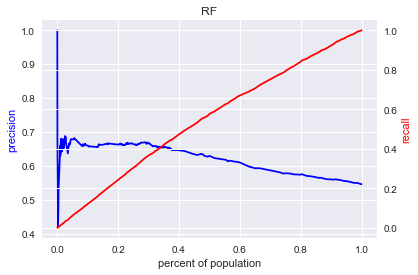

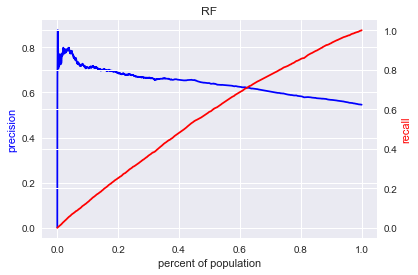

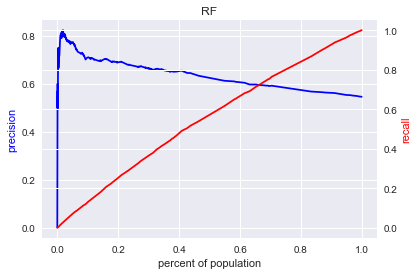

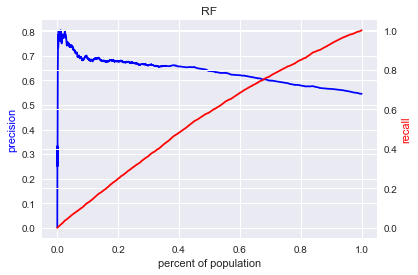

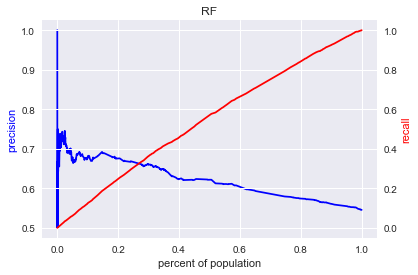

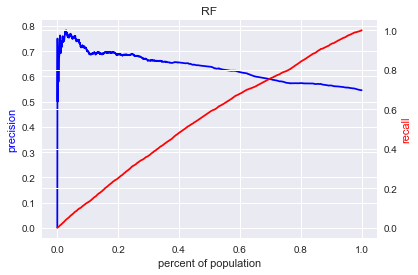

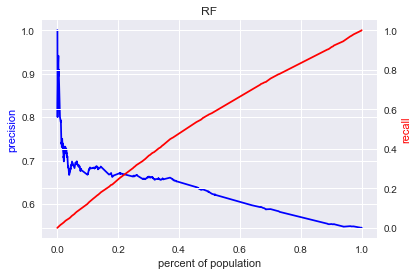

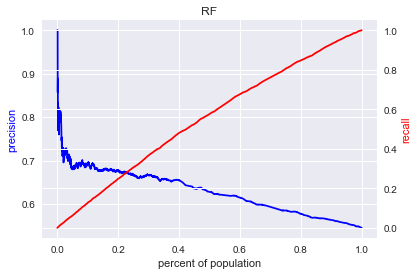

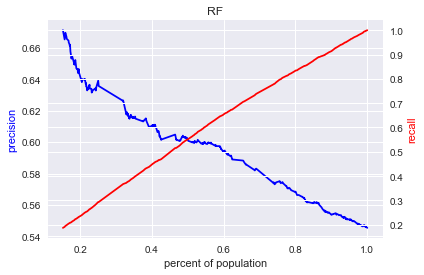

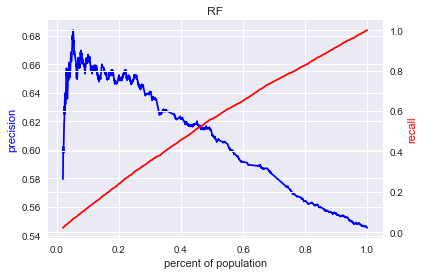

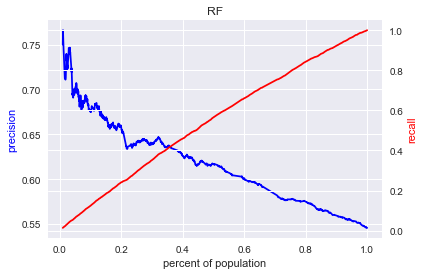

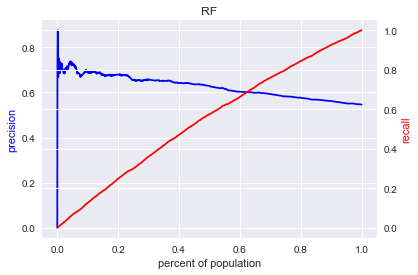

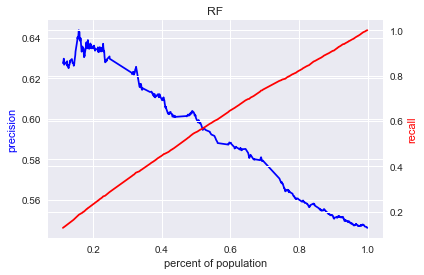

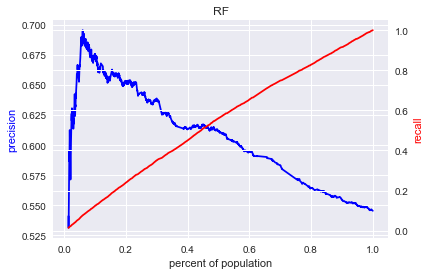

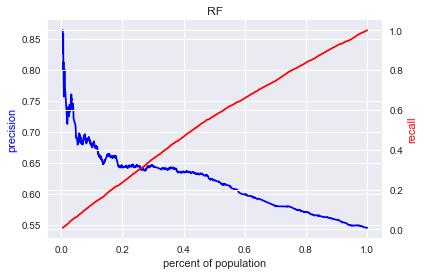

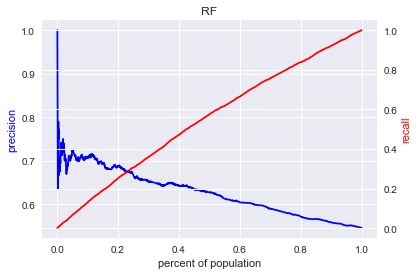

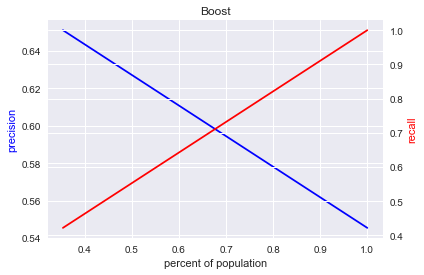

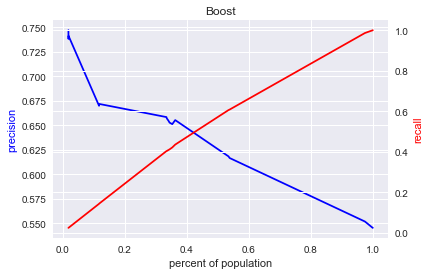

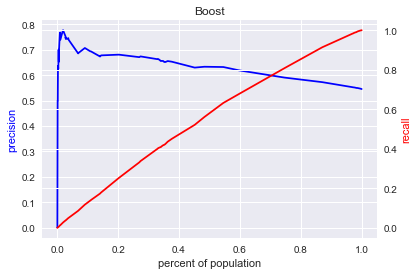

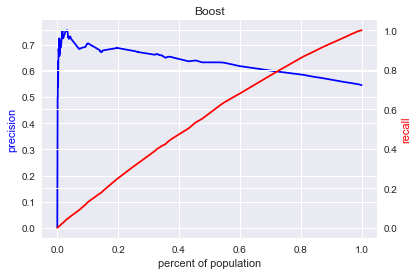

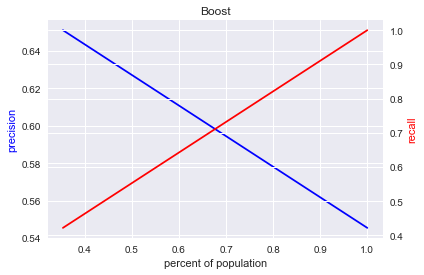

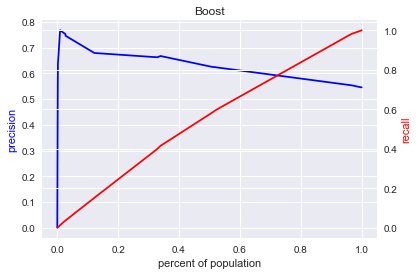

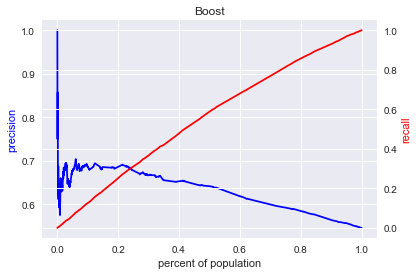

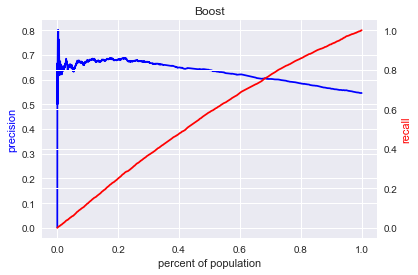

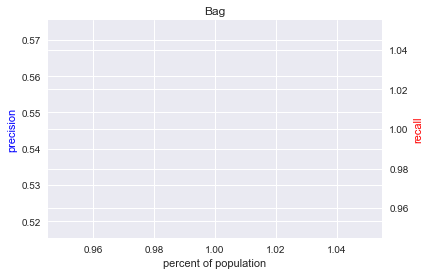

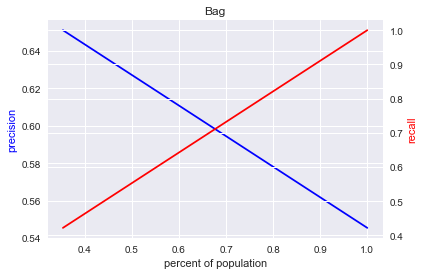

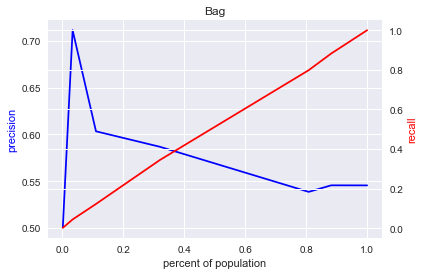

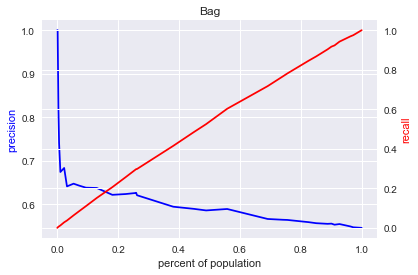

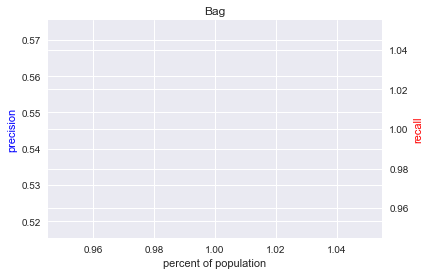

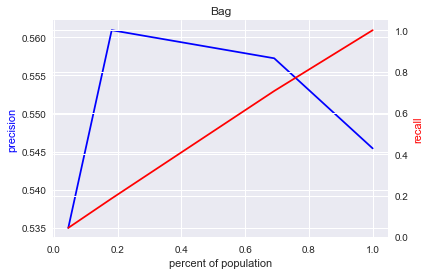

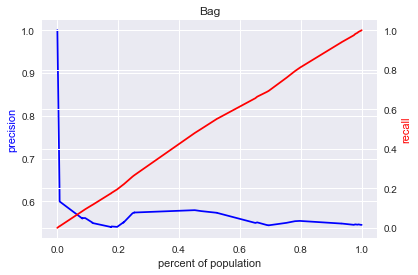

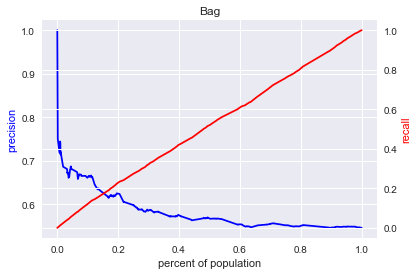

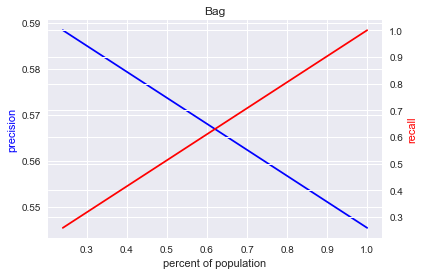

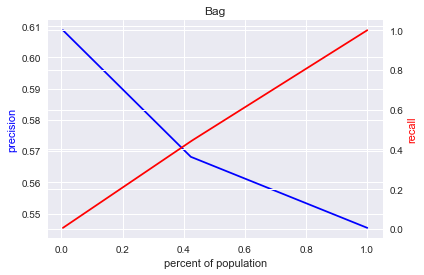

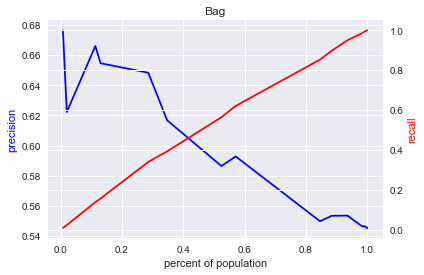

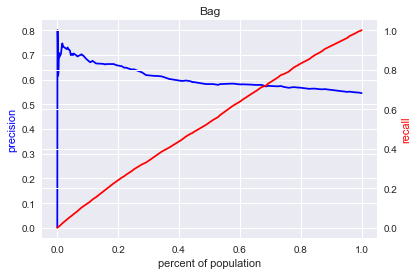

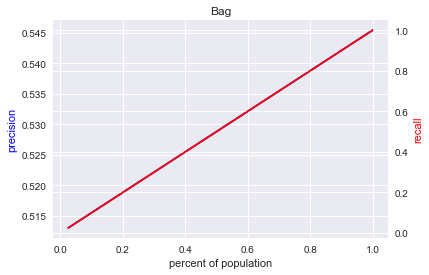

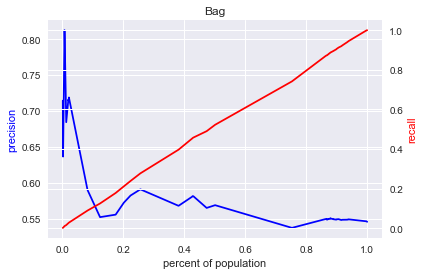

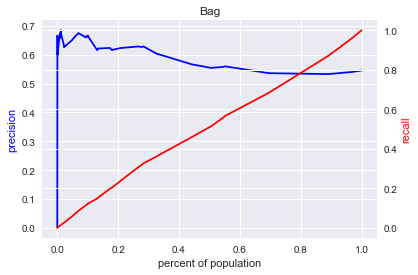

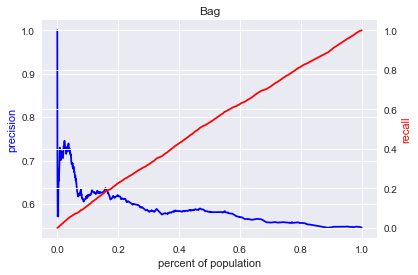

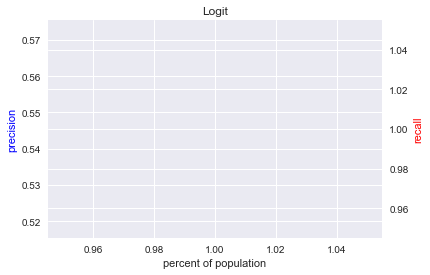

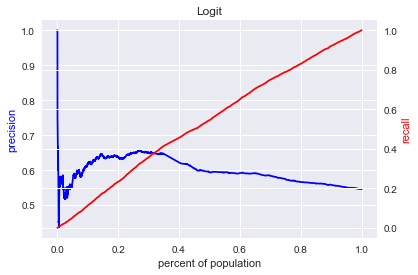

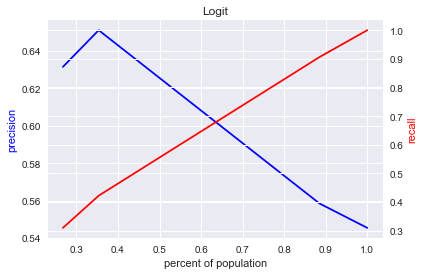

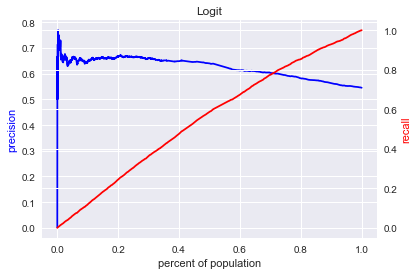

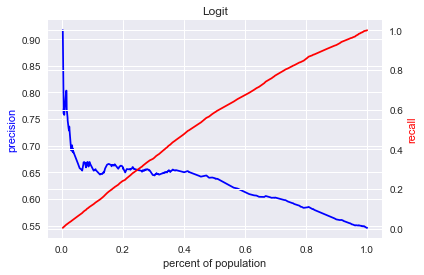

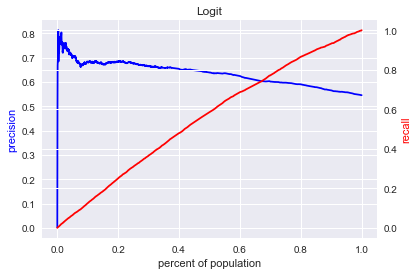

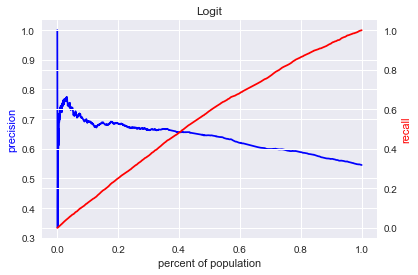

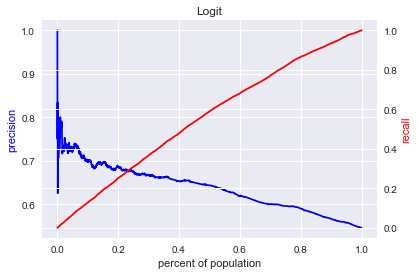

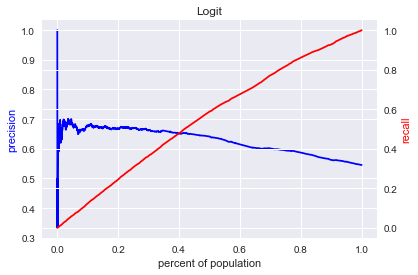

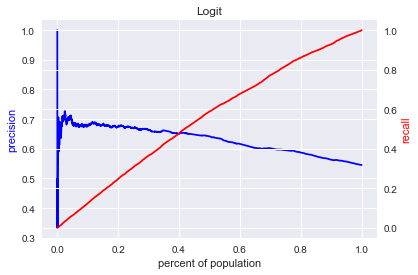

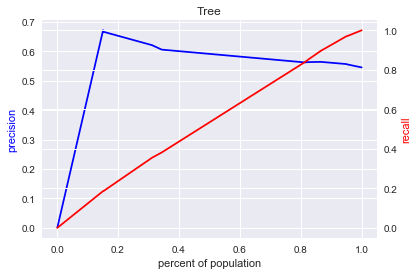

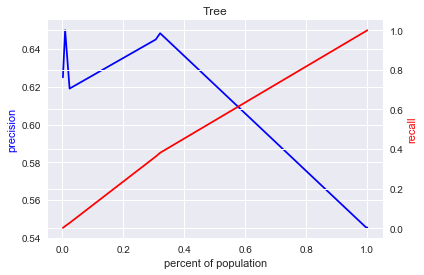

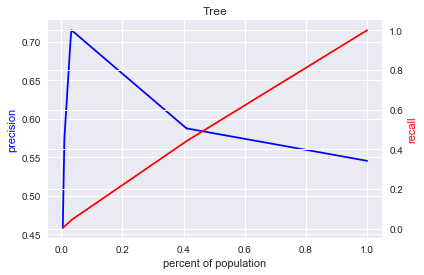

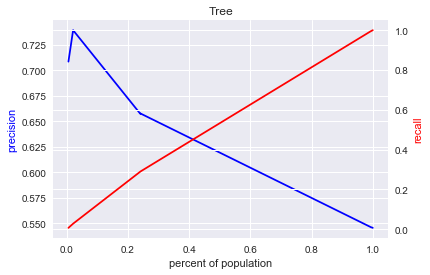

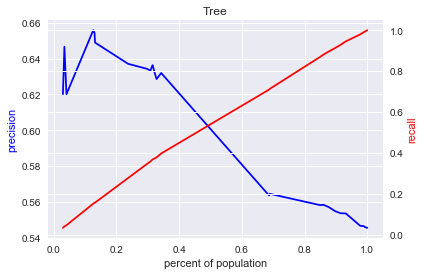

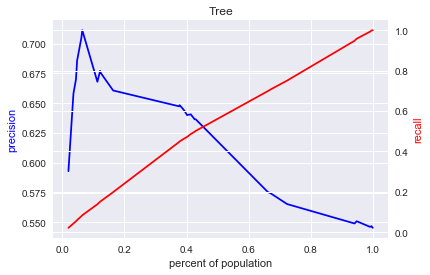

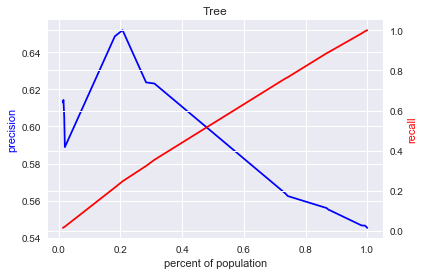

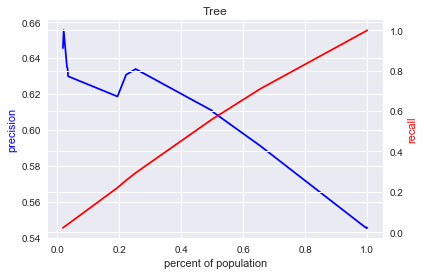

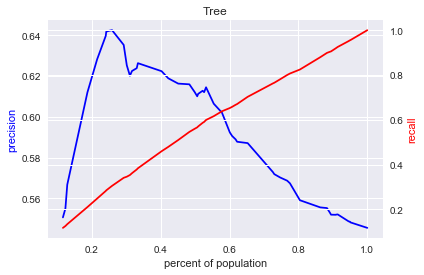

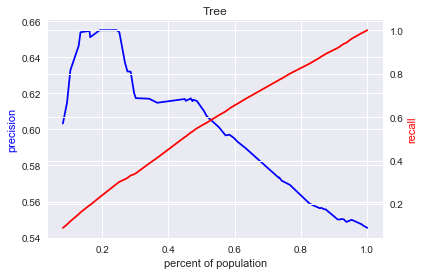

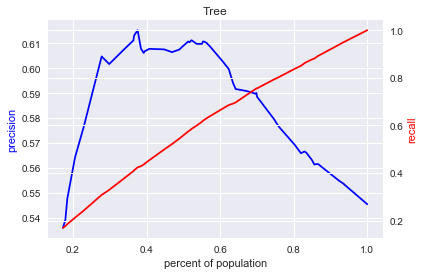

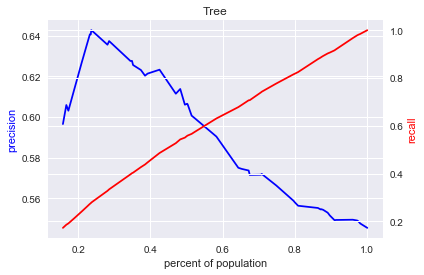

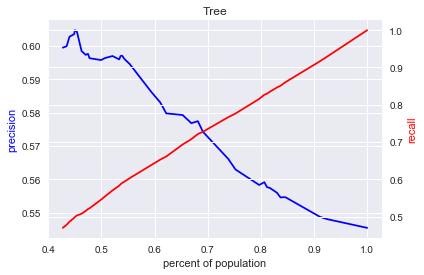

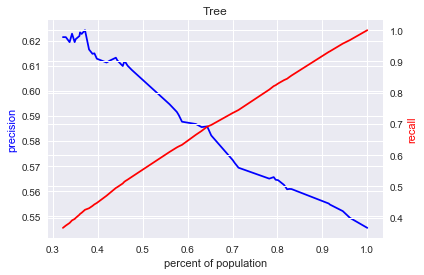

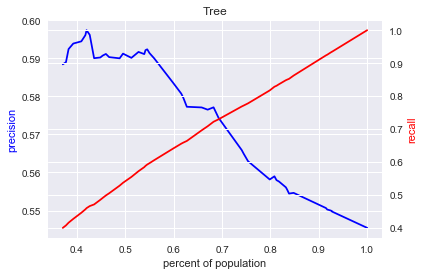

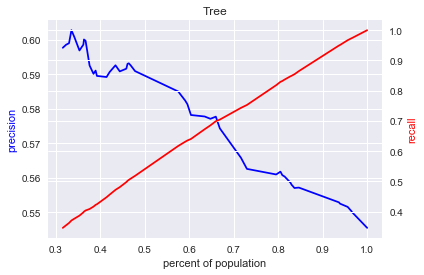

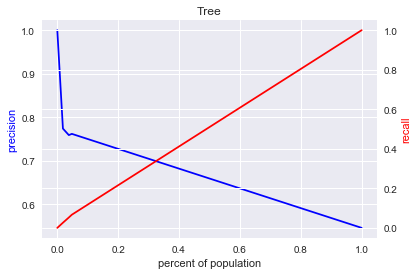

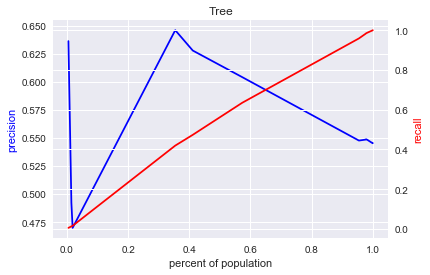

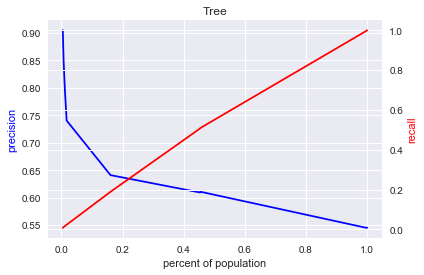

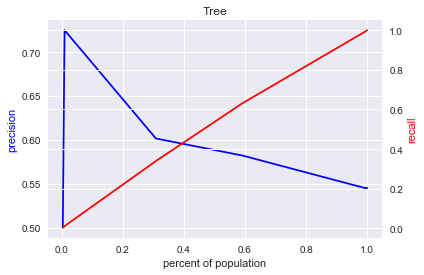

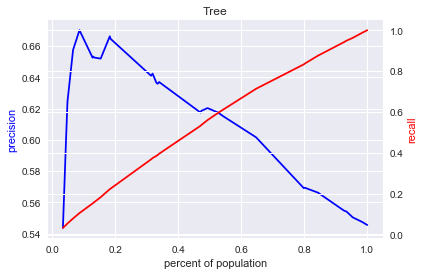

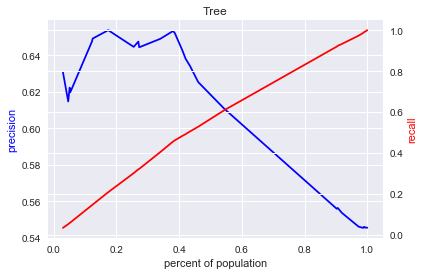

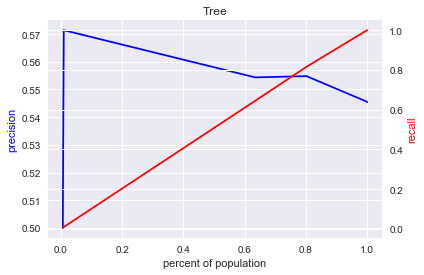

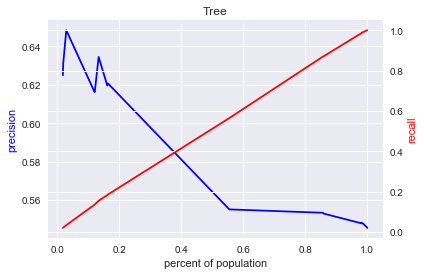

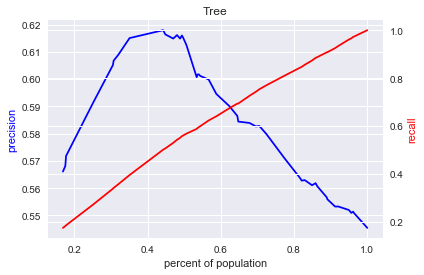

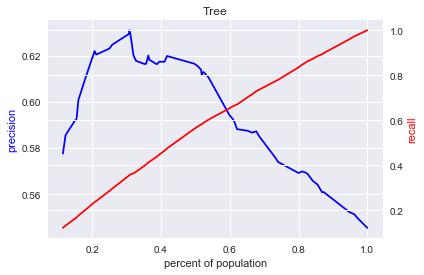

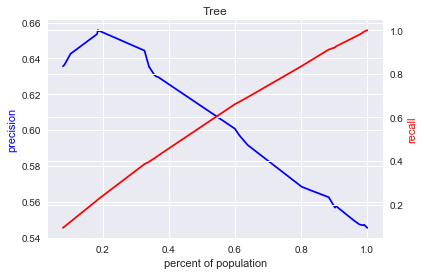

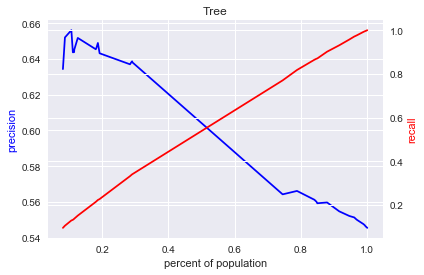

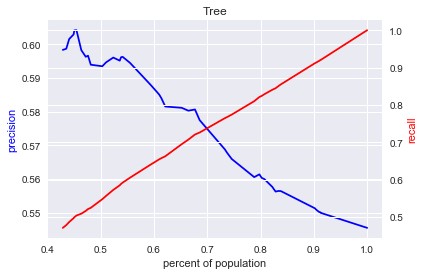

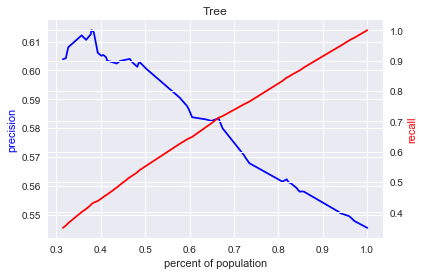

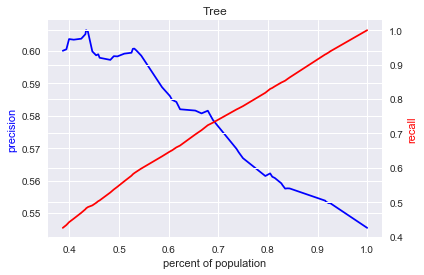

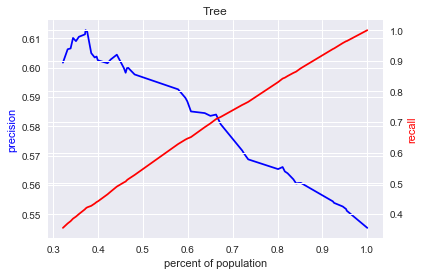

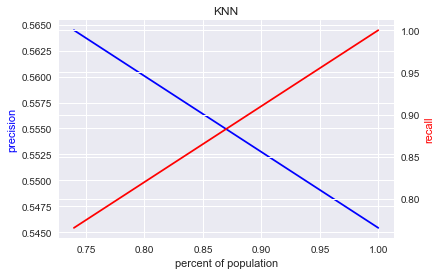

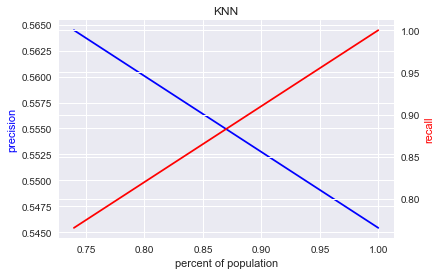

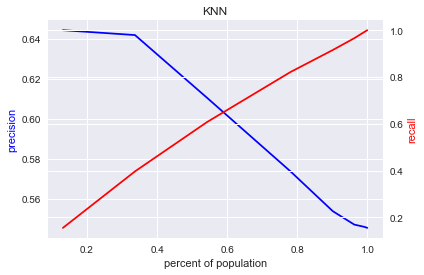

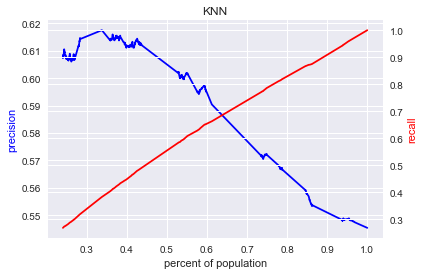

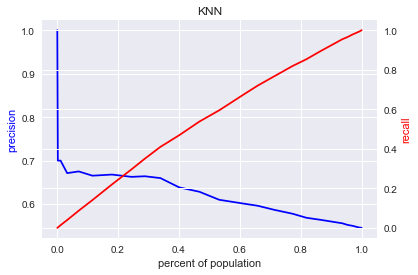

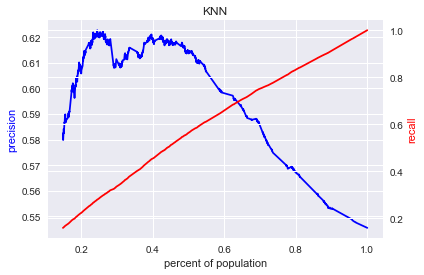

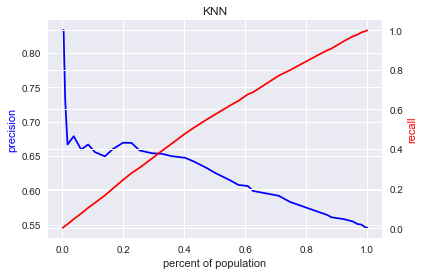

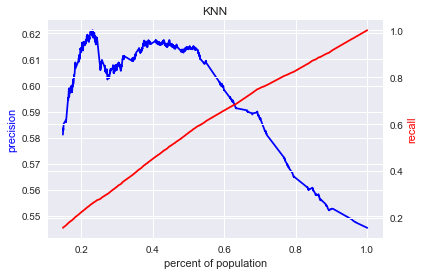

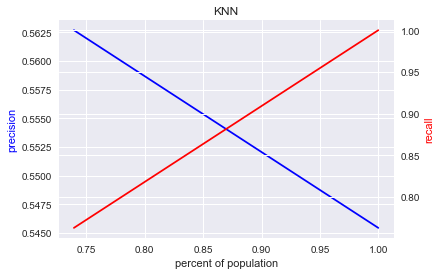

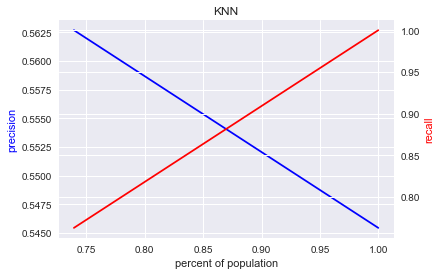

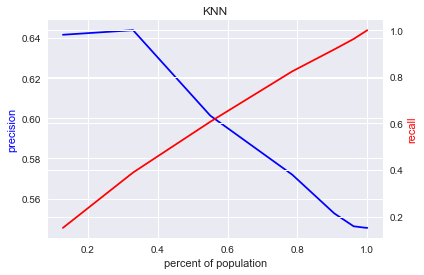

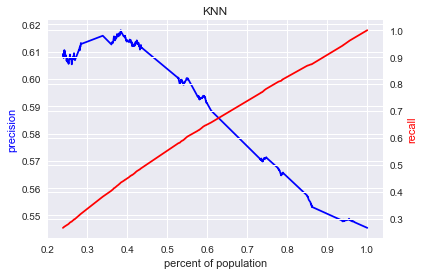

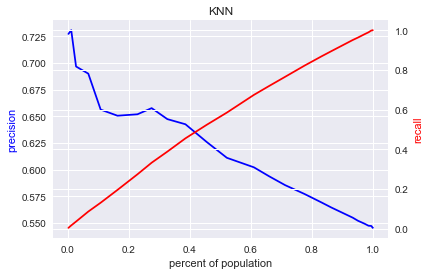

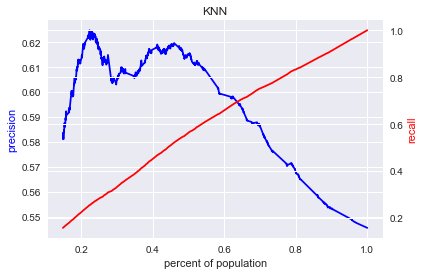

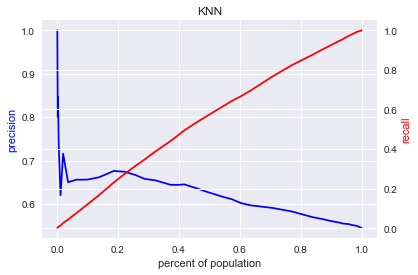

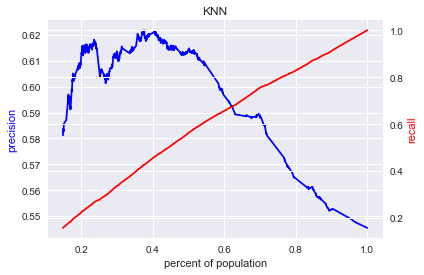

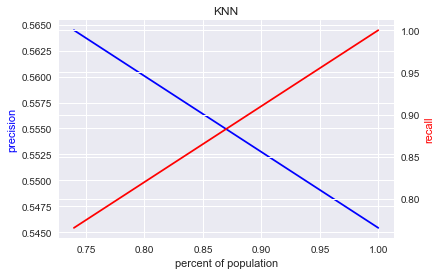

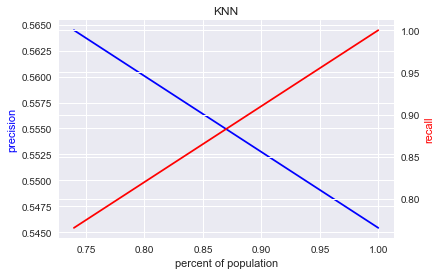

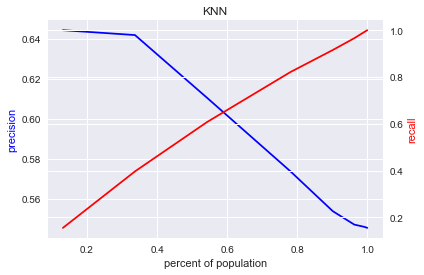

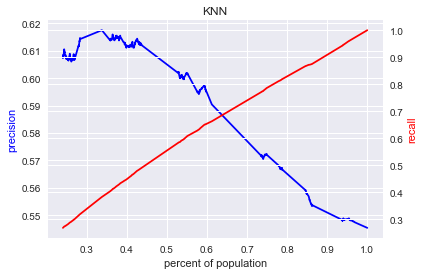

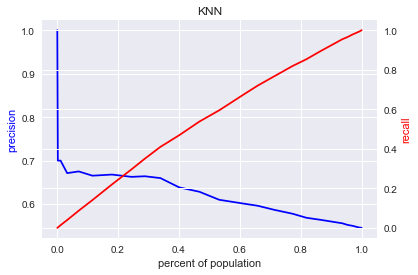

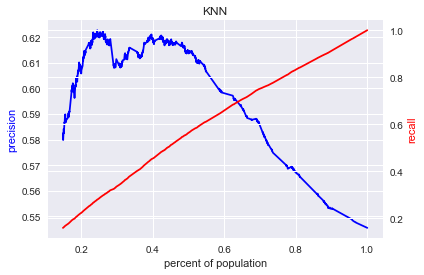

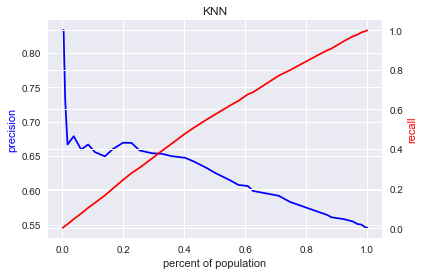

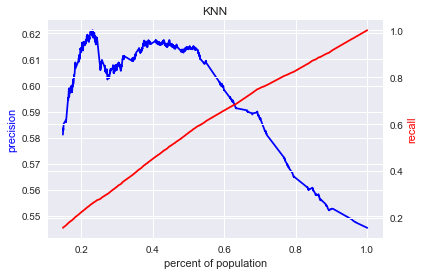

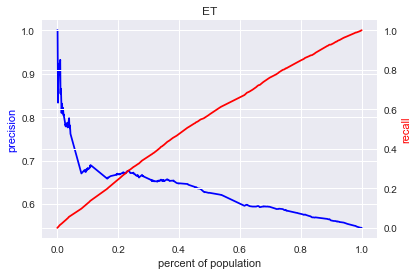

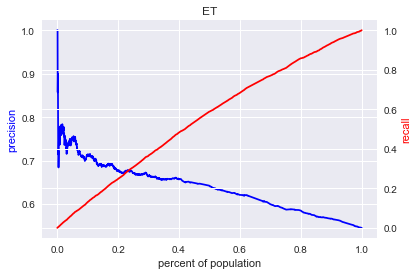

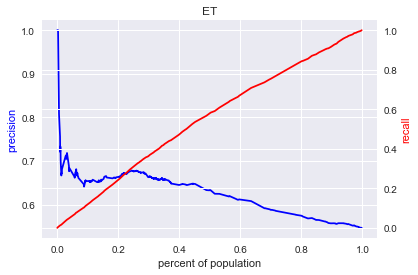

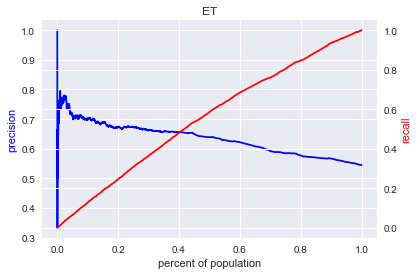

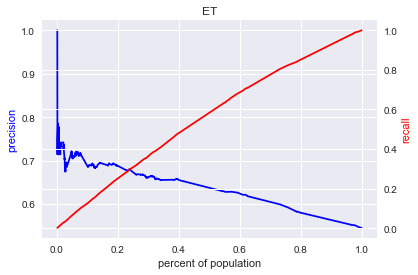

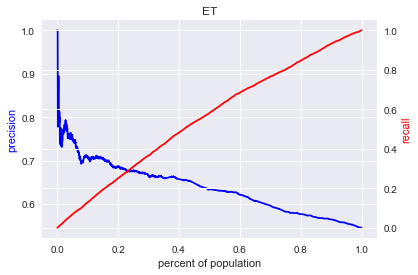

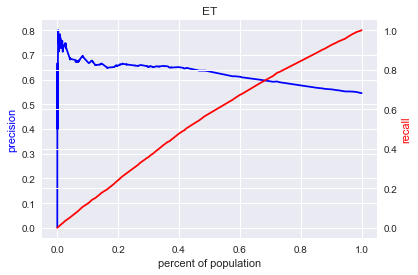

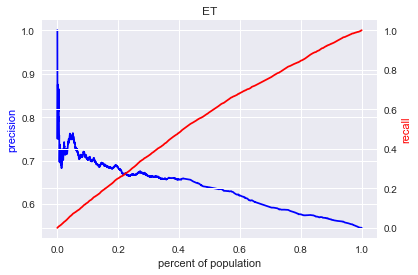

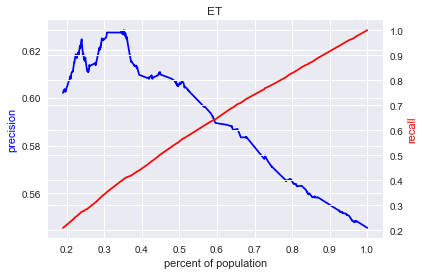

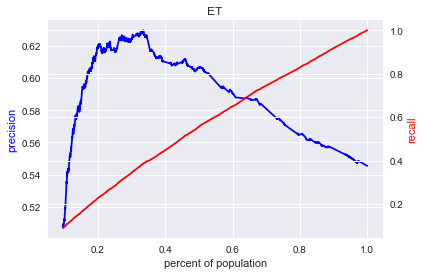

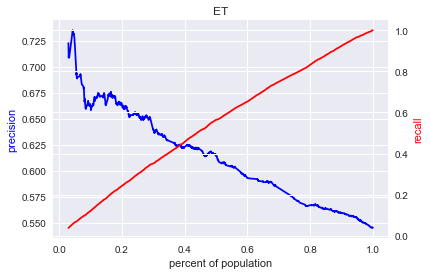

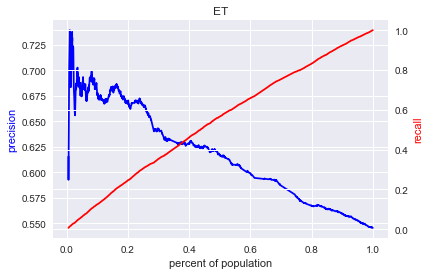

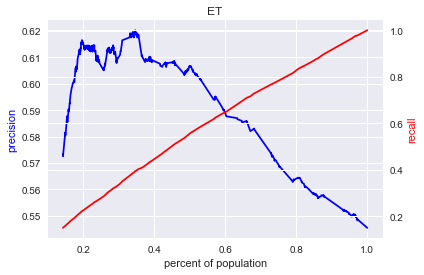

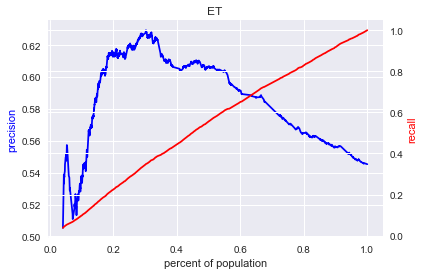

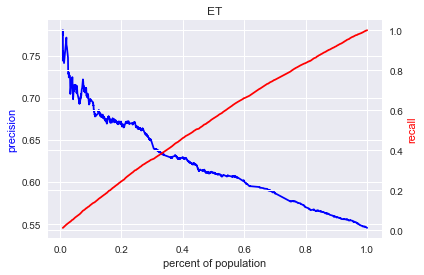

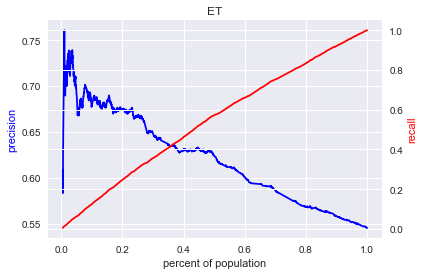

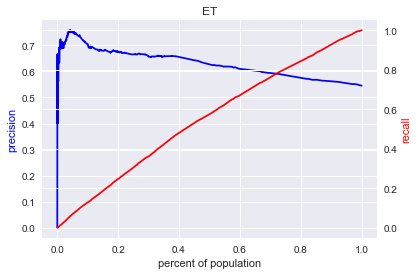

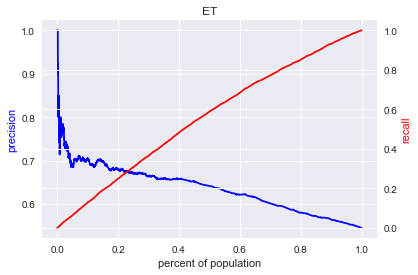

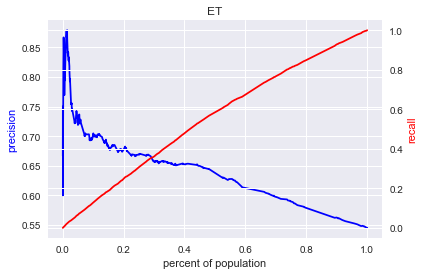

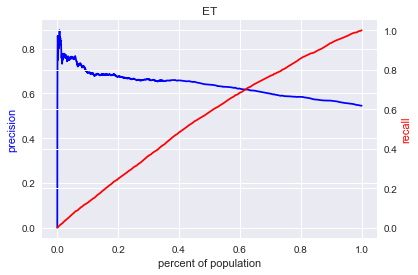

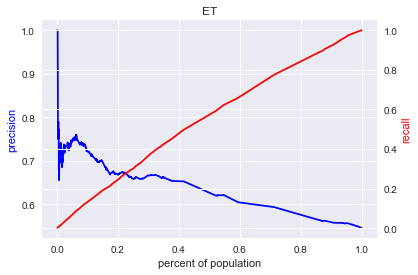

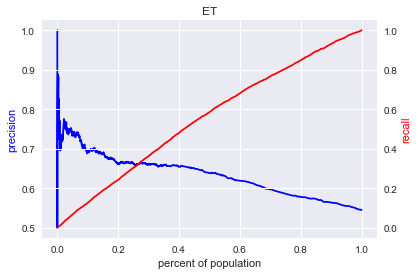

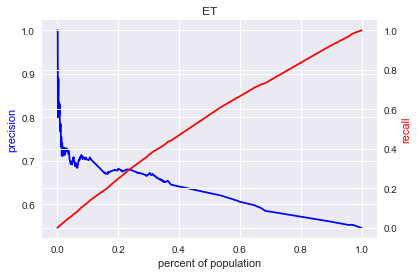

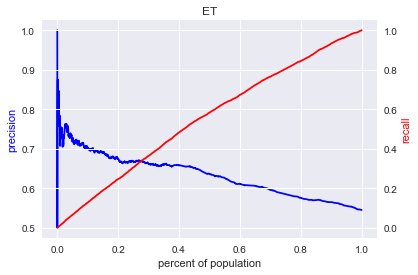

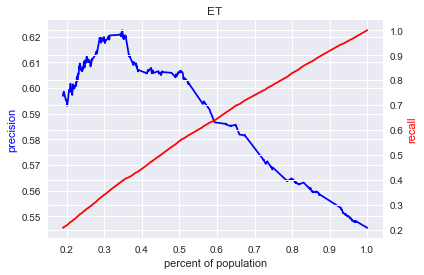

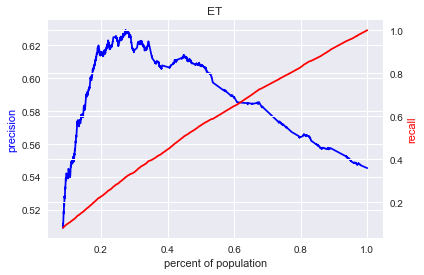

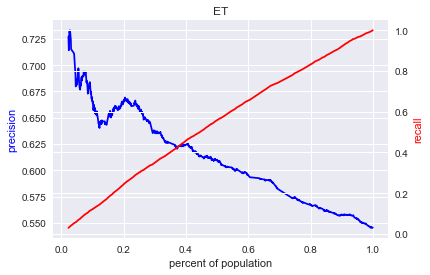

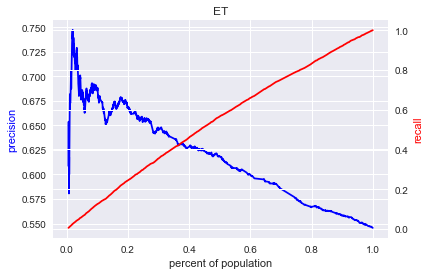

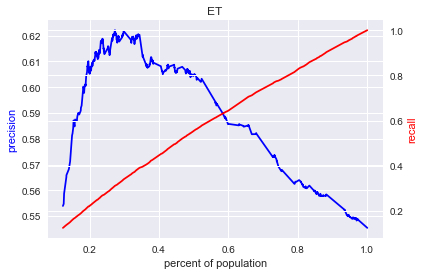

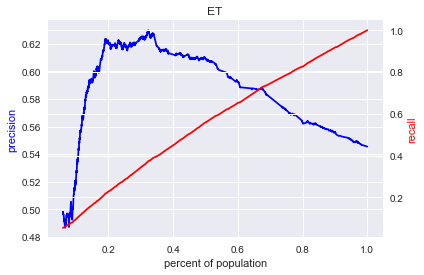

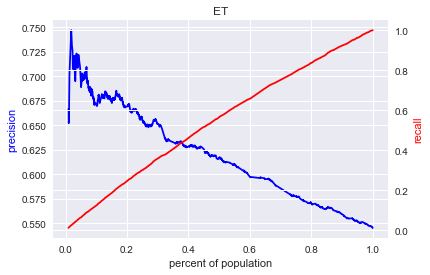

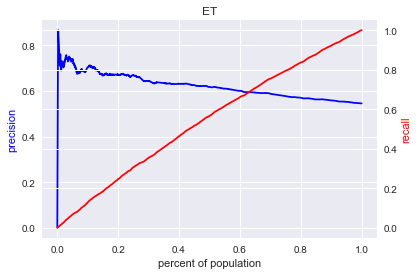

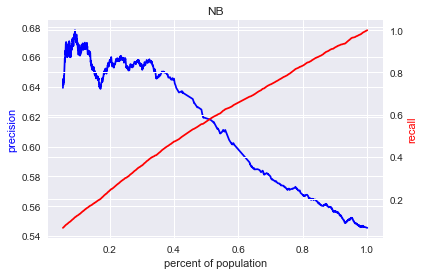

In [62]:
results = clf_loop(["RF", "Boost", "Bag", "Logit", "Tree", "KNN", "ET", "NB"], x_train, x_test, y_train, y_test)

In [63]:
from IPython.display import display
display(results)

model_type                                         parameters  accuracy  \
0           RF  {'max_depth': 5, 'max_features': 'sqrt', 'min_...  0.545434   
1           RF  {'max_depth': 5, 'max_features': 'sqrt', 'min_...  0.545434   
2           RF  {'max_depth': 5, 'max_features': 'sqrt', 'min_...  0.545434   
3           RF  {'max_depth': 5, 'max_features': 'sqrt', 'min_...  0.545434   
4           RF  {'max_depth': 5, 'max_features': 'log2', 'min_...  0.545434   
5           RF  {'max_depth': 5, 'max_features': 'log2', 'min_...  0.545434   
6           RF  {'max_depth': 5, 'max_features': 'log2', 'min_...  0.545434   
7           RF  {'max_depth': 5, 'max_features': 'log2', 'min_...  0.545434   
8           RF  {'max_depth': 50, 'max_features': 'sqrt', 'min...  0.552424   
9           RF  {'max_depth': 50, 'max_features': 'sqrt', 'min...  0.553326   
10          RF  {'max_depth': 50, 'max_features': 'sqrt', 'min...  0.556257   
11          RF  {'max_depth': 50, 'max_features': 'sqrt', 'min...  0.553100   
12          RF  {'max_depth': 50, 'max_features': 'log2', 'min...  0.547012   
13          RF  {'max_depth': 50, 'max_features': 'log2', 'min...  0.552649   
14          RF  {'max_depth': 50, 'max_features': 'log2', 'min...  0.549944   
15          RF  {'max_depth': 50, 'max_features': 'log2', 'min...  0.551973   
16       Boost          {'algorithm': 'SAMME', 'n_estimators': 1}  0.545434   
17       Boost         {'algorithm': 'SAMME', 'n_estimators': 10}  0.545434   
18       Boost        {'algorithm': 'SAMME', 'n_estimators': 100}  0.545434   
19       Boost       {'algorithm': 'SAMME', 'n_estimators': 1000}  0.545434   
20       Boost        {'algorithm': 'SAMME.R', 'n_estimators': 1}  0.545434   
21       Boost       {'algorithm': 'SAMME.R', 'n_estimators': 10}  0.548816   
22       Boost      {'algorithm': 'SAMME.R', 'n_estimators': 100}  0.551297   
23       Boost     {'algorithm': 'SAMME.R', 'n_estimators': 1000}  0.551747   
24         Bag  {'max_features': 5, 'max_samples': 5, 'n_estim...  0.545434   
25         Bag  {'max_features': 5, 'max_samples': 5, 'n_estim...  0.545434   
26         Bag  {'max_features': 5, 'max_samples': 5, 'n_estim...  0.545434   
27         Bag  {'max_features': 5, 'max_samples': 5, 'n_estim...  0.545434   
28         Bag  {'max_features': 5, 'max_samples': 10, 'n_esti...  0.545434   
29         Bag  {'max_features': 5, 'max_samples': 10, 'n_esti...  0.545434   
..         ...                                                ...       ...   
109         ET  {'criterion': 'gini', 'max_depth': 5, 'max_fea...  0.545434   
110         ET  {'criterion': 'gini', 'max_depth': 5, 'max_fea...  0.545434   
111         ET  {'criterion': 'gini', 'max_depth': 5, 'max_fea...  0.545434   
112         ET  {'criterion': 'gini', 'max_depth': 5, 'max_fea...  0.545434   
113         ET  {'criterion': 'gini', 'max_depth': 5, 'max_fea...  0.545434   
114         ET  {'criterion': 'gini', 'max_depth': 50, 'max_fe...  0.555806   
115         ET  {'criterion': 'gini', 'max_depth': 50, 'max_fe...  0.556483   
116         ET  {'criterion': 'gini', 'max_depth': 50, 'max_fe...  0.560090   
117         ET  {'criterion': 'gini', 'max_depth': 50, 'max_fe...  0.555581   
118         ET  {'criterion': 'gini', 'max_depth': 50, 'max_fe...  0.555355   
119         ET  {'criterion': 'gini', 'max_depth': 50, 'max_fe...  0.558286   
120         ET  {'criterion': 'gini', 'max_depth': 50, 'max_fe...  0.557835   
121         ET  {'criterion': 'gini', 'max_depth': 50, 'max_fe...  0.552875   
122         ET  {'criterion': 'entropy', 'max_depth': 5, 'max_...  0.545434   
123         ET  {'criterion': 'entropy', 'max_depth': 5, 'max_...  0.545434   
124         ET  {'criterion': 'entropy', 'max_depth': 5, 'max_...  0.545434   
125         ET  {'criterion': 'entropy', 'max_depth': 5, 'max_...  0.545434   
126         ET  {'criterion': 'entropy', 'max_depth': 5, 'max_...  0.545434   
127         ET  {'criterion': 'entropy', 'max_depth': 

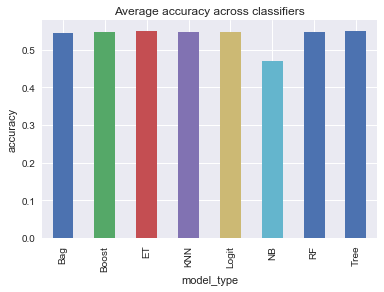

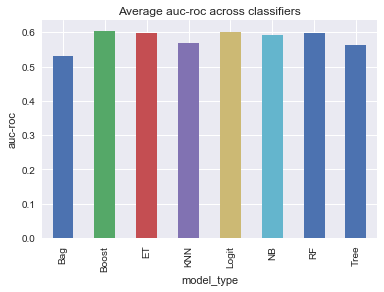

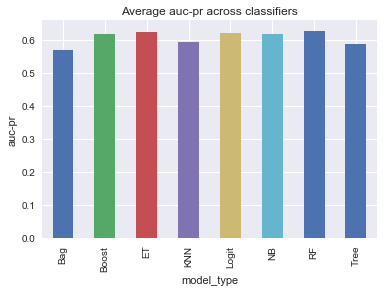

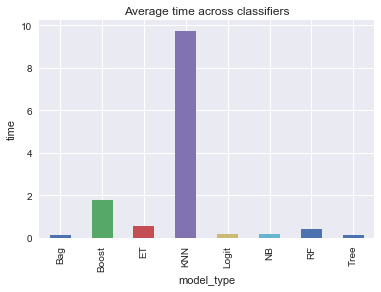

In [64]:
for item in ['accuracy', 'auc-roc','auc-pr','time']:
    plt.figure()
    results.groupby(['model_type'])[item].mean().plot(kind='bar', title='Average '+item+' across classifiers')
    plt.ylabel(item)

In [65]:
models =results.groupby('model_type')['auc-pr'].nlargest(1)

In [66]:
models

model_type     
Bag         35     0.609341
Boost       19     0.637511
ET          111    0.649046
KNN         96     0.625368
Logit       47     0.647433
NB          138    0.618042
RF          1      0.651540
Tree        70     0.608141
Name: auc-pr, dtype: float64

In [67]:
results.loc[[35, 19, 111, 96, 47, 138, 1, 70]].iloc[:,0:6]

model_type                                         parameters  accuracy  \
35         Bag  {'max_features': 10, 'max_samples': 5, 'n_esti...  0.545434   
19       Boost       {'algorithm': 'SAMME', 'n_estimators': 1000}  0.545434   
111         ET  {'criterion': 'gini', 'max_depth': 5, 'max_fea...  0.545434   
96         KNN  {'algorithm': 'ball_tree', 'n_neighbors': 100,...  0.545434   
47       Logit                          {'C': 1, 'penalty': 'l2'}  0.548365   
138         NB                                                 {}  0.469899   
1           RF  {'max_depth': 5, 'max_features': 'sqrt', 'min_...  0.545434   
70        Tree  {'criterion': 'entropy', 'max_depth': 10, 'max...  0.546787   

      auc-roc    auc-pr       time  
35   0.568728  0.609341   0.190362  
19   0.620489  0.637511   5.717111  
111  0.620010  0.649046   0.629356  
96   0.604432  0.625368  10.560715  
47   0.625859  0.647433   0.132726  
138  0.591223  0.618042   0.163166  
1    0.626444  0.651540   0.400264  
70   0.593253  0.608141   0.113191

In [68]:
results.loc[70]['parameters']

{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_split': 2}

In [69]:
#Printing out the best decision tree
dt = DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features='sqrt', min_samples_split=2)

In [70]:
tree = dt.fit(x_train, y_train)

In [71]:
tree_viz = export_graphviz(tree, out_file=None, feature_names=indepv, rounded=True, filled=True)
graph =graphviz.Source(tree_viz)

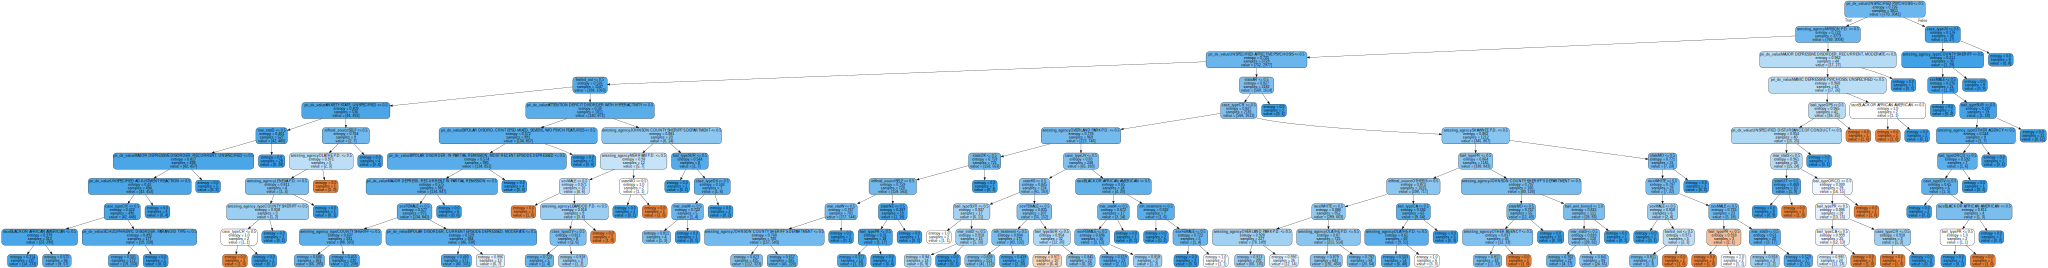

In [72]:
graph

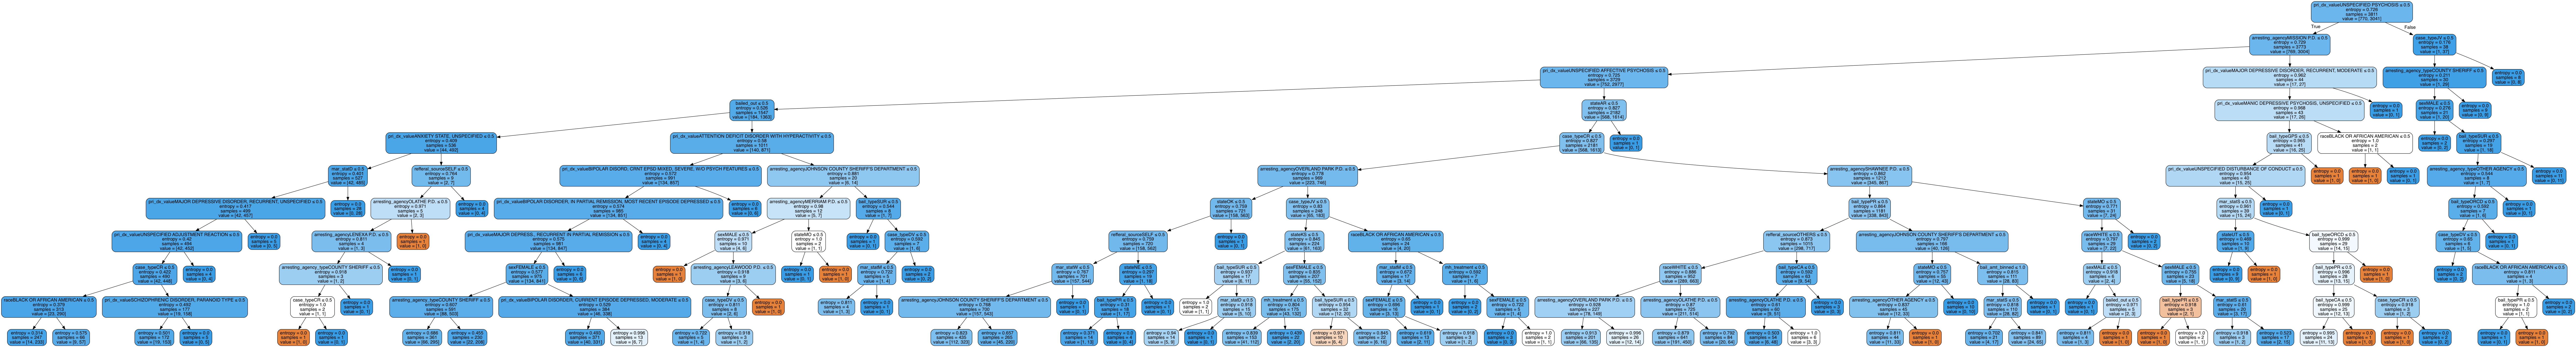

In [73]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(tree, out_file=dot_data,  
                filled=True, feature_names=indepv, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [74]:
graph.write_png('tree.png')

True